In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
dataset_train = pd.read_csv('bitcoin_data.csv')
training_set= dataset_train.iloc[:,1:7].values

In [3]:
print(training_set)


[[6.71690000e+04 6.72147600e+04 6.66100000e+04 6.70841800e+04
  1.23320130e+03 4.79522413e+01]
 [6.70841800e+04 6.72000000e+04 6.67778600e+04 6.71750000e+04
  1.16537046e+03 4.71400434e+01]
 [6.71750100e+04 6.72300000e+04 6.66243900e+04 6.67394800e+04
  1.55696122e+03 4.81526653e+01]
 ...
 [7.04750600e+04 7.05980000e+04 7.03100000e+04 7.03514600e+04
  4.29333780e+02 5.43669111e+01]
 [7.03514600e+04 7.03753300e+04 7.01644600e+04 7.03099900e+04
  3.56292240e+02 5.15969644e+01]
 [7.03100000e+04 7.03316200e+04 6.98220000e+04 6.98280100e+04
  6.23601590e+02 5.06643453e+01]]


In [4]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
print(training_set_scaled)

[[0.49113465 0.45717264 0.46366194 0.48439897 0.12372098 0.45350875]
 [0.48439938 0.45595169 0.47700046 0.49161068 0.1157773  0.44028095]
 [0.49161188 0.45843329 0.4648054  0.45702749 0.16163655 0.45677294]
 ...
 [0.75365767 0.73703367 0.75767208 0.74384281 0.02957994 0.55798082]
 [0.74384301 0.71861444 0.74610715 0.74054981 0.02102604 0.51286828]
 [0.74055081 0.71499876 0.71889452 0.70227738 0.05233067 0.49767924]]


In [5]:
X_train =[]
Y_train= []
for i in range(90,len(training_set)):
    X_train.append(training_set_scaled[i-90:i,0:6])
    Y_train.append(training_set_scaled[i,0])
X_train, Y_train =np.array(X_train), np.array(Y_train)

X_train= np.reshape(X_train, (X_train.shape[0],X_train.shape[1],6))

In [6]:
import torch 
import torch.nn as nn



class LSTM(nn.Module):
    def __init__(self, input_size =6, hidden_layer_size =50, output_size=1):
        super().__init__()
        self.hidden_layer_size =hidden_layer_size
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        self.linear = nn.Linear(hidden_layer_size, output_size)
        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),torch.zeros(1,1,self.hidden_layer_size))

    def forward(self,input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq),1,-1),self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq),-1))
        return predictions[-1]
    
model =LSTM()


loss_function = nn.MSELoss()
optimizer= torch.optim.Adam(model.parameters(),lr=0.001)

X_train_tensor =torch.Tensor(X_train)
Y_train_tensor =torch.Tensor(Y_train)    

epochs = 10

for i in range(epochs):
    model.train()  
    for seq, labels in zip(X_train_tensor, Y_train_tensor):
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                            torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(seq)
        labels = labels.unsqueeze(0)  
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    print(f'Epoch: {i+1:3} Loss: {single_loss.item():10.8f}')

Epoch:   1 Loss: 0.00000284
Epoch:   2 Loss: 0.00000463
Epoch:   3 Loss: 0.00000001
Epoch:   4 Loss: 0.00003043
Epoch:   5 Loss: 0.00000166
Epoch:   6 Loss: 0.00000999
Epoch:   7 Loss: 0.00000308
Epoch:   8 Loss: 0.00000731
Epoch:   9 Loss: 0.00000426
Epoch:  10 Loss: 0.00005749


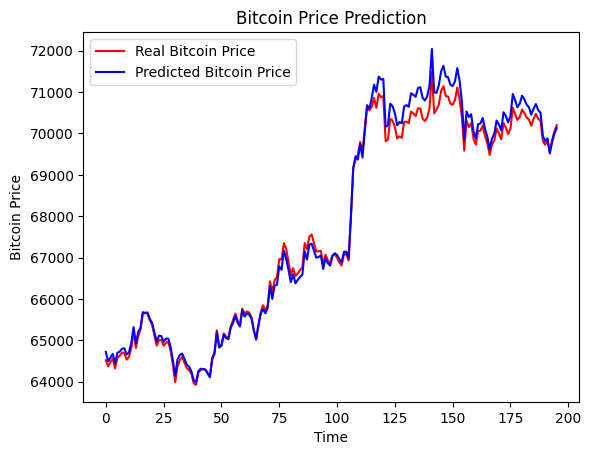

In [12]:

dataset_test = pd.read_csv('bitcoin_data_test.csv')
test_set = dataset_test.iloc[:, 1:7].values
test_set_scaled = sc.fit_transform(test_set)
X_test = []
for i in range(90, len(test_set)):
    X_test.append(test_set_scaled[i-90:i, :]) 

X_test = np.array(X_test)


X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 6))


predicted_stock_price = []
model.eval()
with torch.no_grad():
    for seq in X_test:
        y_pred = model(torch.Tensor(seq).unsqueeze(1))
        predicted_stock_price.append(y_pred.item())
predicted_stock_price = np.array(predicted_stock_price).reshape(-1, 1)

single_feature_scaler = MinMaxScaler()
single_feature_scaler.min_ = np.array([sc.min_[0]])
single_feature_scaler.scale_ = np.array([sc.scale_[0]])
predicted_stock_price = single_feature_scaler.inverse_transform(predicted_stock_price)
# predicted_stock_price = sc.inverse_transform(predicted_stock_price)

real_stock_price = dataset_test.iloc[90:, 1:2].values  

real_stock_price = real_stock_price[:len(predicted_stock_price)]


plt.plot(real_stock_price, color='red', label='Real Bitcoin Price')
plt.plot(predicted_stock_price, color='blue', label='Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.show()




